In [24]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import time
# NOTE: Importing torch the first time will always take a long time!
print(f"Importing torch ...")
import_torch_start_time = time.time() 
import torch
print(f"Importing torch took {time.time() - import_torch_start_time} seconds")

Importing torch ...
Importing torch took 3.075599670410156e-05 seconds


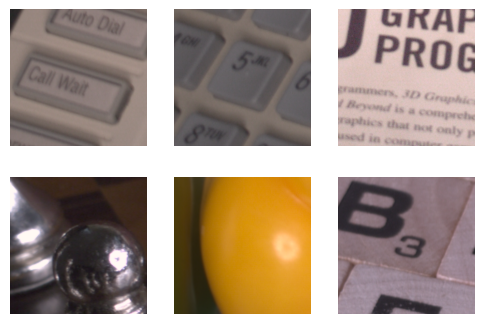

In [5]:
data_path = "data/images/patches"

examples = [
    "0064_GT_SRGB_010_10",
    "0064_GT_SRGB_010_23",
    "0065_GT_SRGB_011_16",
    "0075_GT_SRGB_010_20",
    "0098_GT_SRGB_010_19",
    "0156_GT_SRGB_010_5",
]

example_images = [
    Image.open(f"{data_path}/{ex}.png") for ex in examples
]

def show_examples(examples):
    plt.figure(figsize=(6, 4))
    for i, ex in enumerate(examples):
        example_image = examples[i]
        plt.subplot(2, 3, i+1)
        plt.imshow(example_image, cmap="gray")
        plt.axis("off")
    plt.show();

show_examples(example_images)

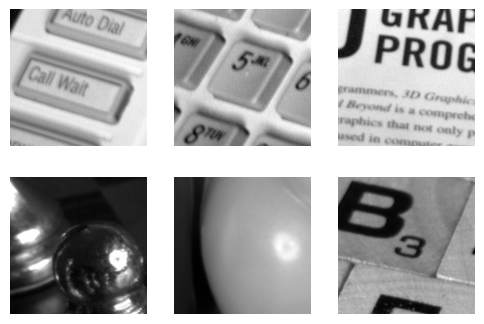

In [15]:
# Test converting to grayscale    
gray_images = [image.convert("L") for image in example_images]
show_examples(gray_images)

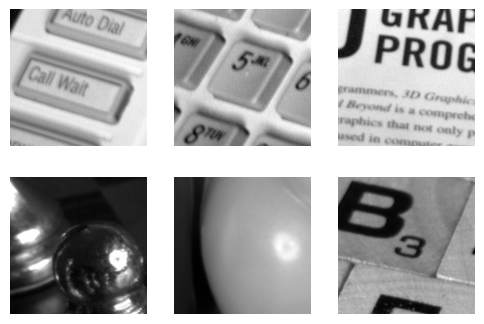

In [16]:
# Test converting to numpy
numpy_images = [np.array(image) for image in gray_images]
for image in numpy_images:
    assert image.shape == (256, 256)
show_examples(numpy_images) # can plot numpy arrays just fine

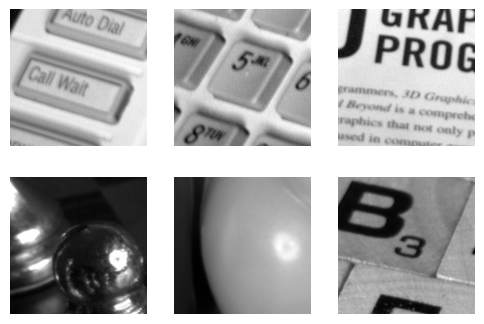

In [28]:
# Test converting to tensor from numpy and back
from helper.convert import numpy_image_to_tensor_4D, tensor_4D_to_numpy_image
image_tensors = [numpy_image_to_tensor_4D(image) for image in numpy_images]
min_value = np.inf
max_value = -np.inf
for image in image_tensors:
    assert image.shape == (1, 256, 256, 1)
    min_value = min(min_value, image.min())
    max_value = max(max_value, image.max())
assert min_value >= 0 and max_value <= 1
numpy_images_reconstructed = [tensor_4D_to_numpy_image(image) for image in image_tensors]
for i in range(len(numpy_images)):
    assert np.allclose(numpy_images[i], numpy_images_reconstructed[i])
show_examples(numpy_images_reconstructed)

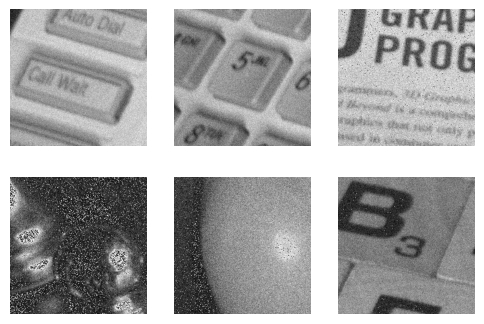

In [29]:
# Test adding noise
from helper.noise import add_gaussian_noise
noisy_image_tensors = [add_gaussian_noise(image, sigma=0.5) for image in image_tensors]
noisy_image_numpy = [tensor_4D_to_numpy_image(image) for image in noisy_image_tensors]
show_examples(noisy_image_numpy)

PSNR: 28.81, SSIM: 0.52


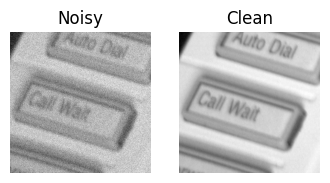

PSNR: 32.20, SSIM: 0.66


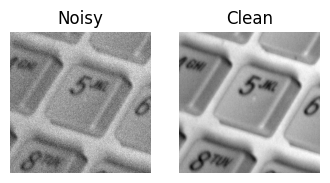

PSNR: 21.76, SSIM: 0.33


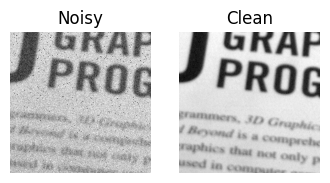

PSNR: 19.68, SSIM: 0.19


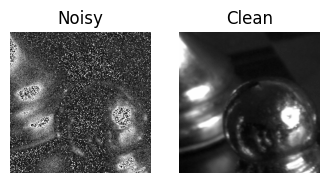

PSNR: 20.64, SSIM: 0.12


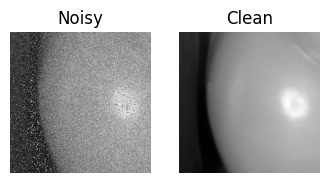

PSNR: 23.58, SSIM: 0.29


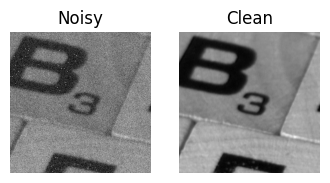

In [40]:
# Test compute PSNR and SSIM
from ignite.metrics import PSNR, SSIM
from ignite.engine import Engine

# create default evaluator for doctests
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
ssim = SSIM(data_range=1.0)
ssim.attach(default_evaluator, 'ssim')

for i in range(len(image_tensors)):
    clean_4D = image_tensors[i]
    noisy_4D = noisy_image_tensors[i]
    # Add batch dimension: (1, 256, 256, 1) -> (1, 256, 256, 1, 1)
    clean_5D = clean_4D.unsqueeze(0)
    noisy_5D = noisy_4D.unsqueeze(0)
    # Remove "time" dimension: (1, 256, 256, 1, 1) -> (1, 256, 256, 1)
    clean_5D = clean_5D.squeeze(-1)
    noisy_5D = noisy_5D.squeeze(-1)
    state = default_evaluator.run([[noisy_5D, clean_5D]])
    print(f"PSNR: {state.metrics['psnr']:.2f}, SSIM: {state.metrics['ssim']:.2f}")
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_image_numpy[i], cmap="gray")
    plt.axis("off")
    plt.title("Noisy")
    plt.subplot(1, 2, 2)
    plt.imshow(numpy_images_reconstructed[i], cmap="gray")
    plt.axis("off")
    plt.title("Clean")
    plt.show();


# preds = torch.rand([4, 3, 16, 16])  # NOTE: shape is [batch, channels, height, width]
# target = preds * 0.75
# state = default_evaluator.run([[preds, target]])
# print(state.metrics['psnr'])
